In [18]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from losses import *
from train import *
from plots import *
from gan import *

import matplotlib.pyplot as plt
from PIL import Image

In [19]:
BATCH_SIZE = 32
LR = 3e-4
BETAS = 0.9, 0.999
class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [20]:
idx2label[569] #target class

'garbage_truck'

In [21]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [49]:
data = torchvision.datasets.ImageFolder("/content/drive/MyDrive/cars_test", transform=preprocess)#torch.tensor(transform.resize(np.array(x), (224, 224, 3))))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)
attacked_model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_1', pretrained=True).eval()
for param in attacked_model.parameters():
    param.requires_grad = False

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [50]:
generator_model = Generator().to(device='cuda')
discriminator_model = Discriminator().to(device='cuda')
attacked_model = attacked_model.to(device='cuda')

In [55]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [56]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cuda'),
                  ResNetLoss(attacked_model, BATCH_SIZE, 'cuda'),
                  discriminator_optimizer, generator_optimizer, 'cuda')

In [57]:
res = trainer.train(train_data, 10)

Epoch: 0, Generator loss: 0.6153385643940048, Discriminator loss: 1.384235933957347, ResNet loss: 7.911424410770614,
Epoch: 1, Generator loss: 0.6389894573337054, Discriminator loss: 1.370736960870811, ResNet loss: 6.668593102717304,
Epoch: 2, Generator loss: 0.6514806604955301, Discriminator loss: 1.3648399741526145, ResNet loss: 6.258717854184458,
Epoch: 3, Generator loss: 0.6651371444363993, Discriminator loss: 1.3552116497579323, ResNet loss: 6.010816617790922,
Epoch: 4, Generator loss: 0.6721719028465302, Discriminator loss: 1.3451273151602878, ResNet loss: 5.838297869579725,
Epoch: 5, Generator loss: 0.6868837264429526, Discriminator loss: 1.3062290409171724, ResNet loss: 5.6865202003266235,
Epoch: 6, Generator loss: 0.6966290082114627, Discriminator loss: 1.2809632118954601, ResNet loss: 5.559252197523991,
Epoch: 7, Generator loss: 0.7071263647649393, Discriminator loss: 1.2517227979295282, ResNet loss: 5.461937972748897,
Epoch: 8, Generator loss: 0.7103807204273117, Discriminat

In [68]:
for i in range(16):
    print(F.softmax(attacked_model(val_batch), -1).cpu().detach().numpy()[i, 569], F.softmax(attacked_model(val_batch + generator_model(val_batch)), -1).cpu().detach().numpy()[i, 569])

2.1690586e-05 0.0072291302
1.6241105e-05 0.0008383989
0.0001554314 0.010263194
1.1655947e-06 8.515314e-05
2.4787485e-05 0.00048066265
6.4872197e-06 0.011773566
5.4675947e-06 0.00412581
0.00012424006 0.0255543
2.4453451e-05 0.0018201976
0.0001048882 0.009703852
5.823809e-07 0.0013326175
1.0945947e-07 0.0004696957
0.004268675 0.06318641
2.4495303e-05 0.019276181
1.01240885e-05 0.0013008106
7.3127035e-06 0.00083928555


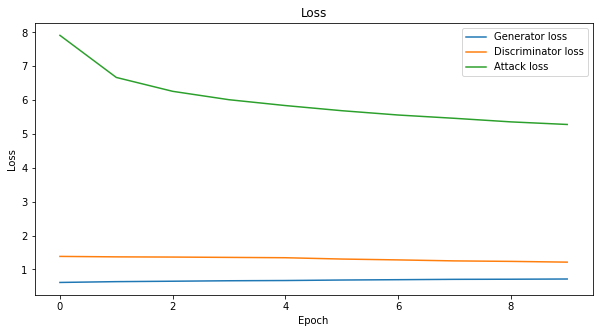

In [59]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()